# Credit Scoring Data Case

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import sys

import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, validation_curve, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, matthews_corrcoef, balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import RFE, SequentialFeatureSelector
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import shap
from imblearn.over_sampling import SMOTE

In [2]:
file_path = '/Users/Bora/Desktop/CaseStudyData.xlsx'
   
df = pd.read_excel(file_path, sheet_name=0)               # Data
variable_names = pd.read_excel(file_path, sheet_name=1)   # Variable Description

df = df.drop(columns=df.columns[0])

new_column_names = variable_names['Description'].tolist()
df.columns = new_column_names
df.rename(columns={'Good_Bad_Flag': 'Target'}, inplace=True)
df.head()

,Target,CC Num of application_L1M,Worst Account Status All Credits,Any Legal Action YN,Existing Credit Card Previous Limit,LO Num of application_L6M,TS Last Legal Action,TS Oldest Open Credit Card,CC TS First Open Active Credit Card,Last Credit Decision,...,LO TS First Open Date,MO Number of months in 1 delay_L6M,MO Number of months in 3 or more delay_L6M,E Mail Given YN,OD_Pending Credit_YN,CC Number of months in 2 delay_L12M,Num Unpaid Cards L25M-L36M,Guarantee YN,Overridden_From_Final_Decline_YN,CC Existing Customers in L6M
0,0,0,L,Y,1750.0,1,36.0,86,2606,A,...,5.0,NaN,NaN,Y,N,NaN,0,N,N,Y
1,0,0,1,N,1300.0,12,NaN,13,406,R,...,15.0,NaN,NaN,Y,N,NaN,0,N,N,Y
2,0,0,0,N,0.0,0,NaN,274,8337,A,...,NaN,NaN,NaN,Y,N,NaN,0,N,N,N
3,1,0,L,Y,800.0,3,37.0,6,8,A,...,NaN,NaN,NaN,N,N,NaN,0,N,N,Y
4,0,0,1,N,6250.0,0,NaN,126,3833,A,...,NaN,0.0,NaN,Y,N,NaN,0,N,N,N


In [3]:
missing_values = df.isnull().sum()
missing_percentage = df.isnull().mean() * 100

missing_values_array = missing_values.values
missing_percentage_array = missing_percentage.values

print(f"{'Column':<30} {'Missing Values':<20} {'Missing Percentage (%)':<20}")
for column, value, percentage in zip(df.columns, missing_values_array, missing_percentage_array):
    print(f"{column:<30} {value:<20} {percentage:<20.2f}")

Column                         Missing Values       Missing Percentage (%)
Target                         0                    0.00                
CC Num of application_L1M      0                    0.00                
Worst Account Status All Credits 0                    0.00                
Any Legal Action YN            0                    0.00                
Existing Credit Card Previous Limit 8471                 24.49               
LO Num of application_L6M      0                    0.00                
TS Last Legal Action           29034                83.95               
TS Oldest Open Credit Card     0                    0.00                
CC TS First Open Active Credit Card 0                    0.00                
Last Credit Decision           9048                 26.16               
Total Assets_3                 15                   0.04                
Any Legal Action no date YN    28346                81.96               
TS Last Closed good account    4032  

In [4]:
column_name = 'Num Unpaid Cards L25M-L36M'  

zero_percentage = (df[column_name] == 0).mean() * 100
print(f"Sütundaki 0 değerlerinin yüzdesi: {zero_percentage:.2f}%")

Sütundaki 0 değerlerinin yüzdesi: 99.80%


In [5]:
# %95'ten fazla eksik değere sahip sütunları düşür
high_missing_cols = missing_percentage[missing_percentage > 95].index
df = df.drop(columns=high_missing_cols)
df.drop('Num Unpaid Cards L25M-L36M', axis=1, inplace=True)

print("Columns dropped due to >95% missing values:", high_missing_cols)

Columns dropped due to >95% missing values: Index(['OD Number of months in 2 delay_L24M', 'Worst Status of All Loans_L3Y',
       'MO Number of months in 3 or more delay_L24M',
       'MO Number of months in 3 or more delay_L6M',
       'CC Number of months in 2 delay_L12M'],
      dtype='object')


### Train-Test Split

In [6]:
X = df.drop(columns=['Target'])
y = df['Target']

# Eğitim ve test setlerini ayırt etmek için flag ekleme
X['TrainFlag'] = True

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Test seti için TrainFlag'i False yap
X_test['TrainFlag'] = False

# Eğitim ve test setlerini birleştir
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)


# Object tipli sütunlar doğrudan kategorik olarak seçiliyor
object_categorical_cols = X_combined.select_dtypes(include='object').columns.tolist()


# Manuel olarak kontrol edilen sütunları buraya ekleyin (eğer varsa)
manual_categorical_cols = ['Residential Status']  # Manuel giriş yapmanız gereken sütunlar

# Tüm kategorik sütunları birleştiriyoruz
categorical_cols = object_categorical_cols + manual_categorical_cols

# Sonrasında bu sütunları one-hot veya target encoding için ayırıyoruz
category_counts = X_combined[categorical_cols].nunique()

one_hot_cols = category_counts[category_counts < 5].index.tolist()
target_encode_cols = category_counts[category_counts >= 5].index.tolist()

print(f"One-hot encoding yapılacak sütunlar: {one_hot_cols}")
print(f"Target encoding yapılacak sütunlar: {target_encode_cols}")

One-hot encoding yapılacak sütunlar: ['Any Legal Action YN', 'Last Credit Decision', 'Any Legal Action no date YN', 'Home Phone YN', 'Employers Address YN', 'PO Credit Exisits_YN', 'CB Unpaid Notes_Cheques YN', 'E Mail Given YN', 'OD_Pending Credit_YN', 'Guarantee YN', 'Overridden_From_Final_Decline_YN', 'CC Existing Customers in L6M']
Target encoding yapılacak sütunlar: ['Worst Account Status All Credits', 'CC Worst Payment Status_L24M', 'Residential Status']


In [7]:
categorical_cols

['Worst Account Status All Credits',
 'Any Legal Action YN',
 'Last Credit Decision',
 'Any Legal Action no date YN',
 'Home Phone YN',
 'Employers Address YN',
 'PO Credit Exisits_YN',
 'CC Worst Payment Status_L24M',
 'CB Unpaid Notes_Cheques YN',
 'E Mail Given YN',
 'OD_Pending Credit_YN',
 'Guarantee YN',
 'Overridden_From_Final_Decline_YN',
 'CC Existing Customers in L6M',
 'Residential Status']

### One-Hot Encoding

In [8]:
# "Other" kategorisi oluşturma (target encoding yapılacak sütunlarda)
for col in target_encode_cols:
    if 5 <= X_combined[col].nunique() <= 20:
        freq_table = X_combined[col].value_counts(normalize=True)
        to_replace = freq_table[freq_table < 0.05].index  # %5'ten az görülen kategorileri "Other" ile değiştir
        X_combined[col] = X_combined[col].replace(to_replace, 'Other')

# One-hot encoding uygulama
X_combined_onehot = pd.get_dummies(X_combined[one_hot_cols], drop_first=True)
X_combined = X_combined.drop(columns=one_hot_cols)
X_combined = pd.concat([X_combined, X_combined_onehot], axis=1)

### Target Encoding

In [9]:
X_train_processed = X_combined[X_combined['TrainFlag'] == True].drop(columns=['TrainFlag'])
X_test_processed = X_combined[X_combined['TrainFlag'] == False].drop(columns=['TrainFlag'])

target_encoder = TargetEncoder(cols=target_encode_cols, smoothing=0.3, min_samples_leaf=10)
# Eğitim verisine fit ve transform 
X_train_processed[target_encode_cols] = target_encoder.fit_transform(X_train_processed[target_encode_cols], y_train)

# Test verisine sadece transform 
X_test_processed[target_encode_cols] = target_encoder.transform(X_test_processed[target_encode_cols])

In [10]:
y_train.value_counts(normalize=True)

Target
0    0.952326
1    0.047674
Name: proportion, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

Target
0    0.952291
1    0.047709
Name: proportion, dtype: float64

### Correlation Matrix

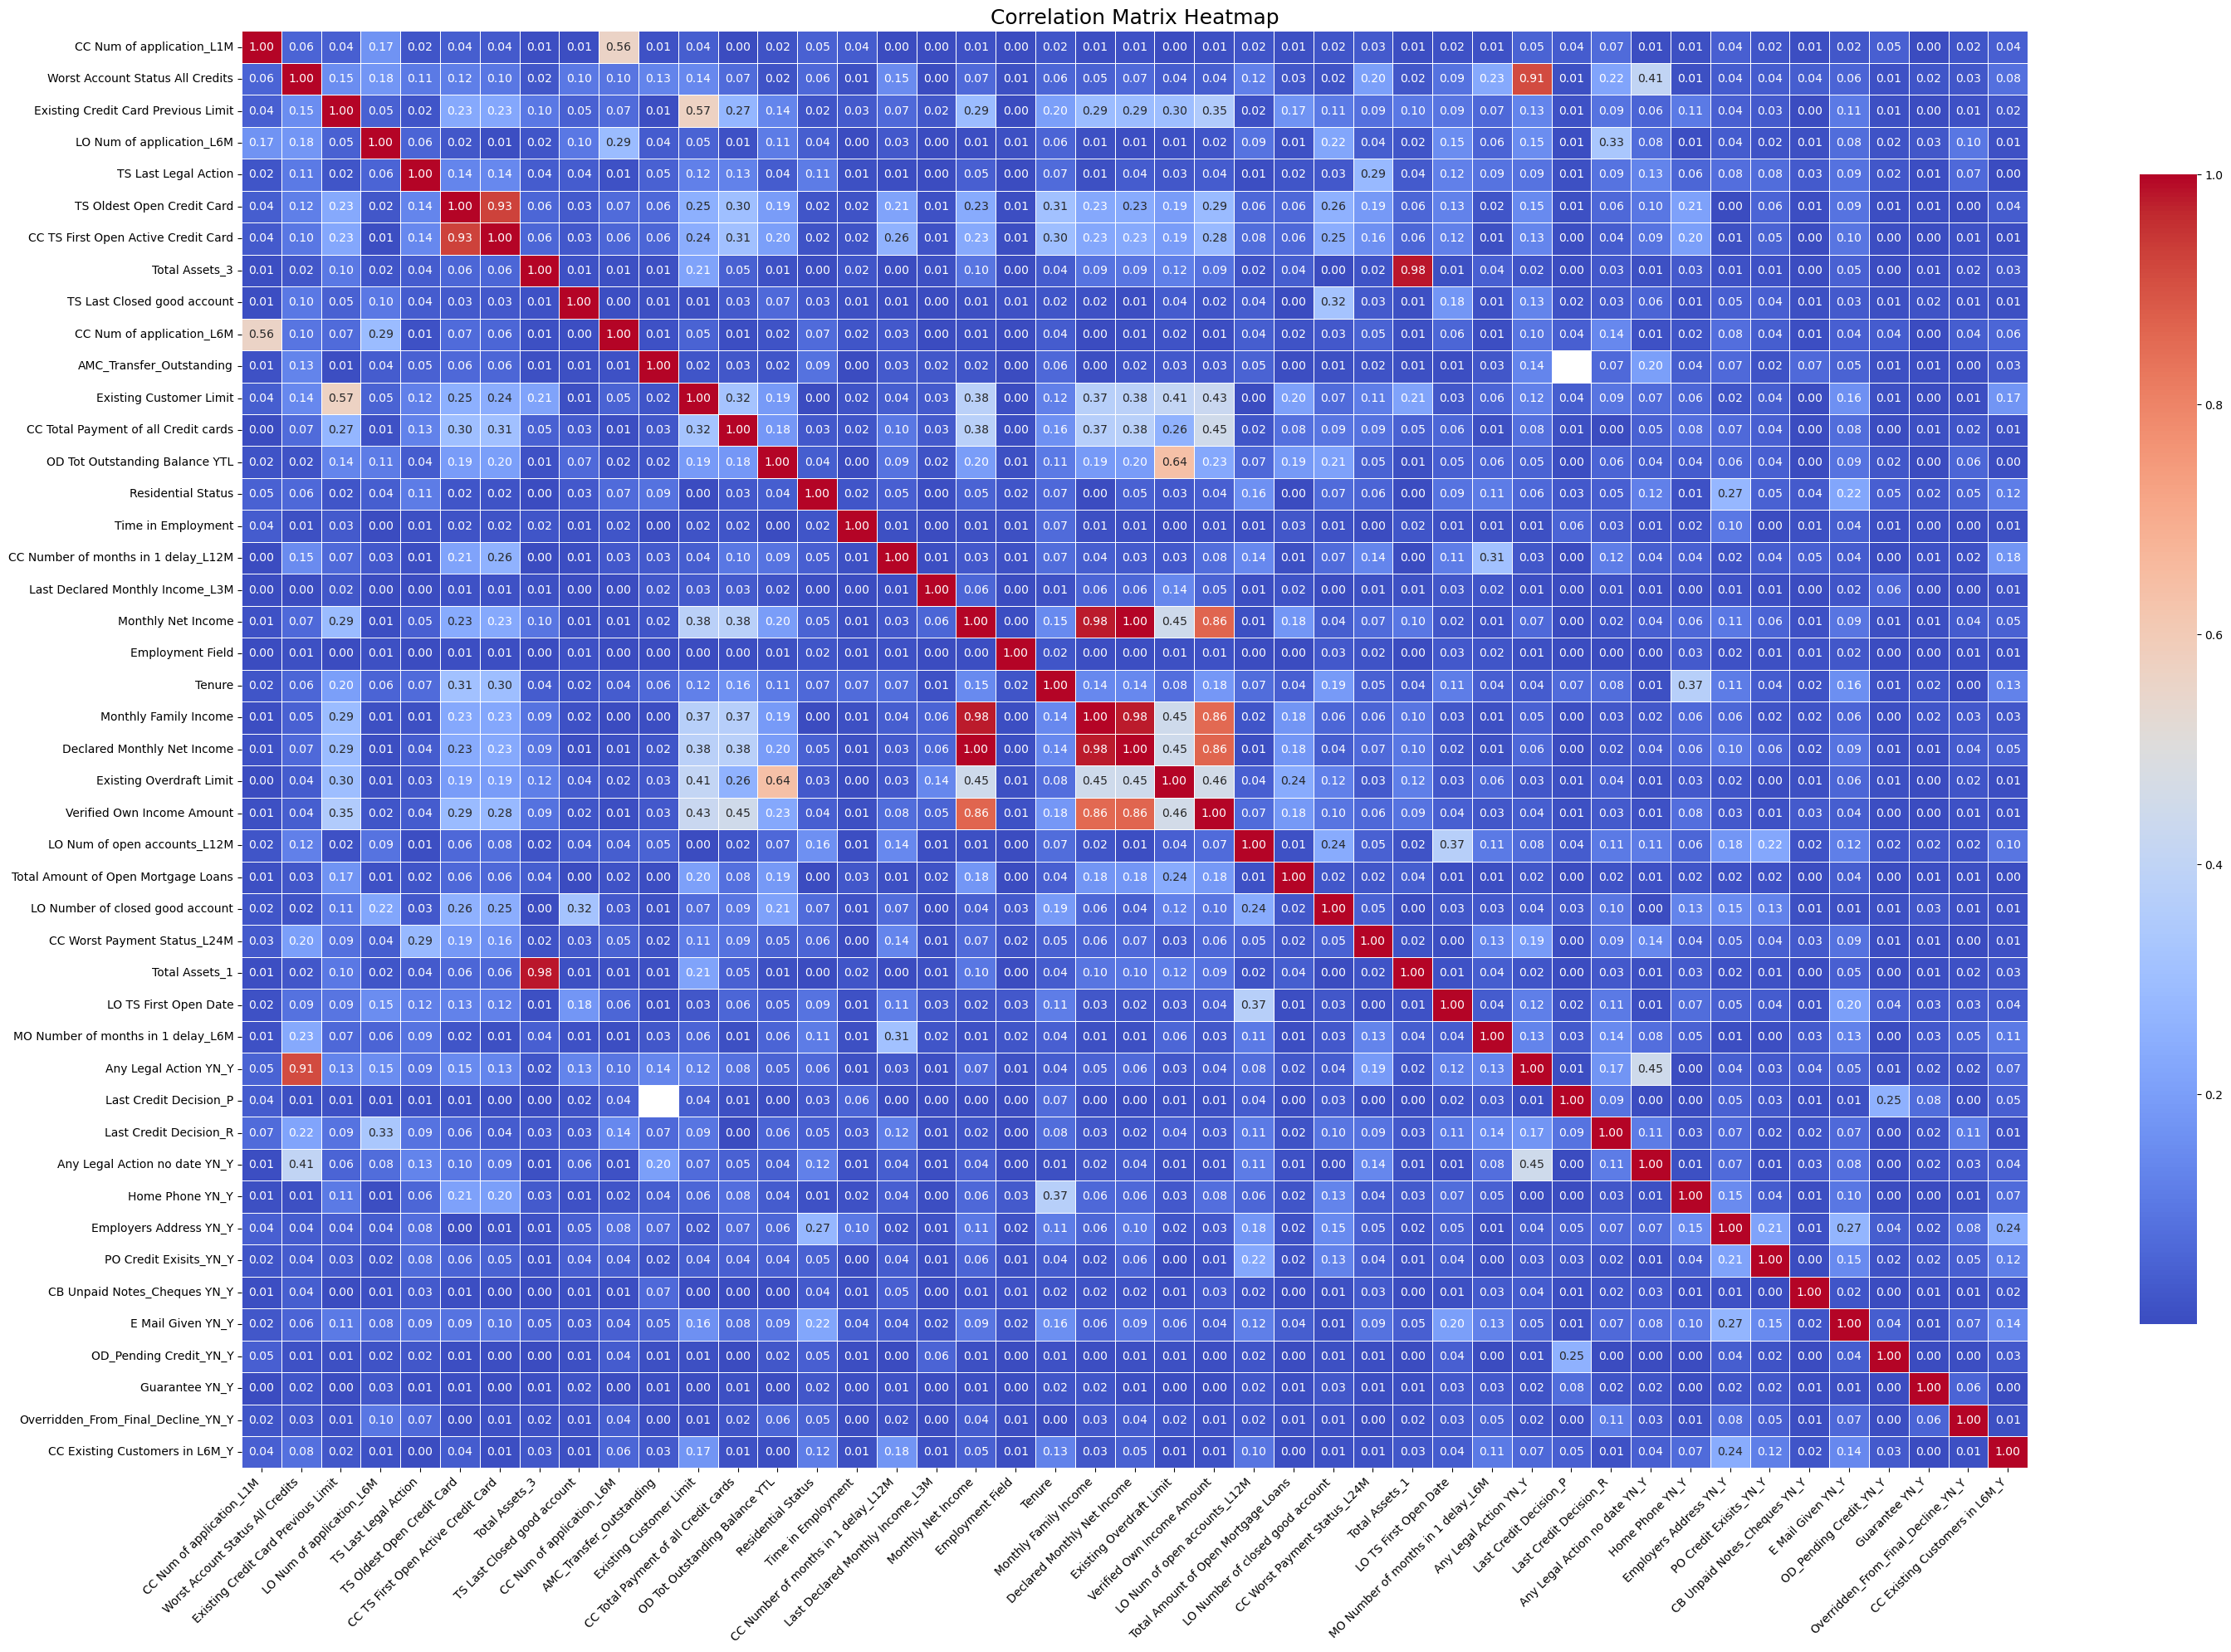

In [12]:
corr_matrix = X_train_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = set()

for column in upper.columns:
    if column not in to_drop:
        correlated_features = upper[upper[column] > 0.85].index
        for feature in correlated_features:
            if feature != column:
                to_drop.add(feature)

features_to_drop = list(to_drop)
X_train_processed = X_train_processed.drop(columns=features_to_drop)
X_test_processed = X_test_processed.drop(columns=features_to_drop)

plt.figure(figsize=(30, 20))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})

plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
print(f"Korelasyon nedeniyle çıkarılan sütunlar: {features_to_drop}")

Korelasyon nedeniyle çıkarılan sütunlar: ['Worst Account Status All Credits', 'Declared Monthly Net Income', 'Monthly Net Income', 'Total Assets_3', 'TS Oldest Open Credit Card', 'Monthly Family Income']


### Imputation and Scaling for Models

In [14]:
# XGBoost/LightGBM için herhangi bir imputation veya scaling yapmıyoruz
X_train_xgb_lgb = X_train_processed
X_test_xgb_lgb = X_test_processed

categorical_cols = [
    'Any Legal Action_YN_Y',
    'Last Credit Decision_P',
    'Last Credit Decision_R',
    'Any Legal Action no date YN_Y',
    'Home Phone YN_Y',
    'Employers Address YN_Y',
    'PO Credit Exisits_YN_Y',
    'CB Unpaid Notes_Cheques YN_Y',
    'E Mail Given YN_Y',
    'OD_Pending Credit_YN_Y',
    'Guarantee YN_Y',
    'Overridden_From_Final_Decline_YN_Y',
    'CC Existing Customers in L6M_Y'
]

# Random Forest için: Kategorik verileri mod ile, sayısal verileri median 
X_train_rf = X_train_processed
X_test_rf = X_test_processed

numerical_cols = [col for col in X_train_rf.columns if col not in categorical_cols]

for column in X_train_rf.columns:
    if column in categorical_cols:  # Kategorik değişkenler
        X_train_rf[column].fillna(X_train_rf[column].mode()[0], inplace=True)
        X_test_rf[column].fillna(X_train_rf[column].mode()[0], inplace=True)
    else:  # Sayısal değişkenler
        X_train_rf[column].fillna(X_train_rf[column].median(), inplace=True)
        X_test_rf[column].fillna(X_train_rf[column].median(), inplace=True)

# Logistic Regression için scaling
scaler = StandardScaler()
X_train_lr = pd.DataFrame(scaler.fit_transform(X_train_rf), columns=X_train_rf.columns)
X_test_lr = pd.DataFrame(scaler.transform(X_test_rf), columns=X_test_rf.columns)

## SFS and Validation Curve

### LR

In [49]:
model = LogisticRegression(n_jobs=5)
sfs = SFS(model,
          k_features=20,  
          forward=True,       
          floating=True,    
          scoring='average_precision',      
          cv=5)              

sfs = sfs.fit(X_train_lr, y_train)

selected_features = X_train_lr.columns[list(sfs.k_feature_idx_)]
print('Seçilen Özellikler:', selected_features)

Seçilen Özellikler: Index(['CC Num of application_L1M', 'Existing Credit Card Previous Limit',
       'LO Num of application_L6M', 'CC TS First Open Active Credit Card',
       'TS Last Closed good account', 'CC Num of application_L6M',
       'Existing Customer Limit', 'CC Total Payment of all Credit cards',
       'Time in Employment', 'Employment Field', 'Existing Overdraft Limit',
       'Total Amount of Open Mortgage Loans',
       'LO Number of closed good account', 'Total Assets_1',
       'LO TS First Open Date', 'Employers Address YN_Y',
       'PO Credit Exisits_YN_Y', 'Guarantee YN_Y',
       'Overridden_From_Final_Decline_YN_Y', 'CC Existing Customers in L6M_Y'],
      dtype='object')


In [50]:
selected_features = X_train_lr.columns[list(sfs.k_feature_idx_)]
X_train_sfs_lr = X_train_lr[selected_features]
X_test_sfs_lr = X_test_lr[selected_features]

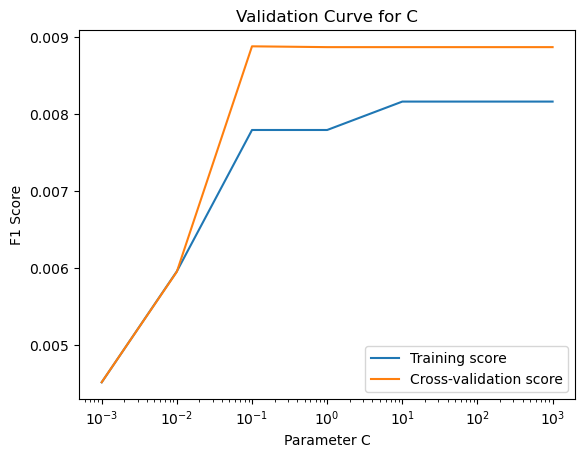

In [51]:
param_range = np.logspace(-3, 3, 7)

train_scores, test_scores = validation_curve(
    LogisticRegression(penalty='l2', solver='liblinear'), 
    X_train_sfs_lr, y_train, param_name='C', param_range=param_range,
    scoring='f1', n_jobs=-1, cv=5
)

plt.figure()
plt.semilogx(param_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(param_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Parameter C')
plt.ylabel('F1 Score')
plt.title('Validation Curve for C')
plt.legend(loc='best')
plt.show()

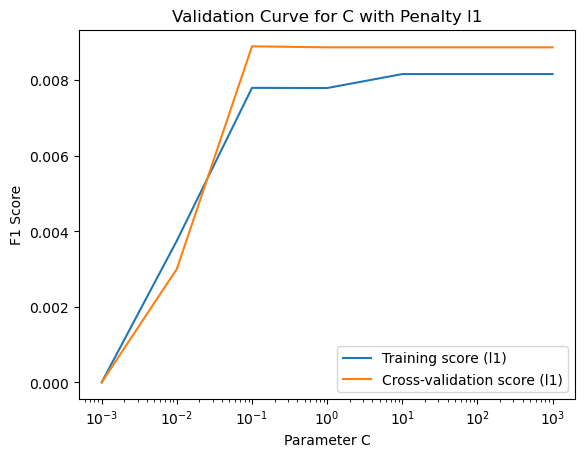

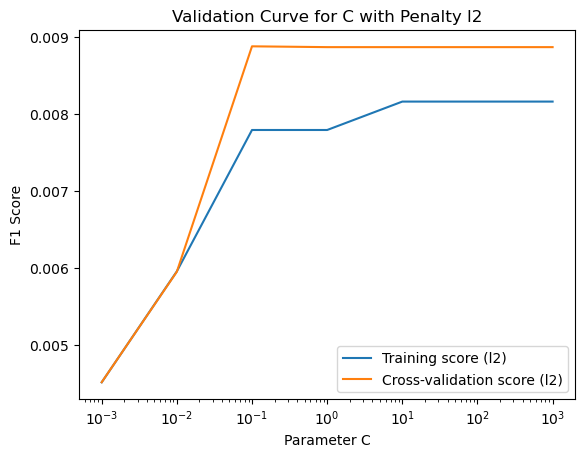

In [52]:
penalties = ['l1', 'l2']
for penalty in penalties:
    train_scores, test_scores = validation_curve(
        LogisticRegression(penalty=penalty, solver='liblinear'),
        X_train_sfs_lr, y_train, param_name='C', param_range=param_range,
        scoring='f1', n_jobs=-1, cv=5
    )
    
    plt.figure()
    plt.semilogx(param_range, np.mean(train_scores, axis=1), label=f'Training score ({penalty})')
    plt.semilogx(param_range, np.mean(test_scores, axis=1), label=f'Cross-validation score ({penalty})')
    plt.xlabel('Parameter C')
    plt.ylabel('F1 Score')
    plt.title(f'Validation Curve for C with Penalty {penalty}')
    plt.legend(loc='best')
    plt.show()


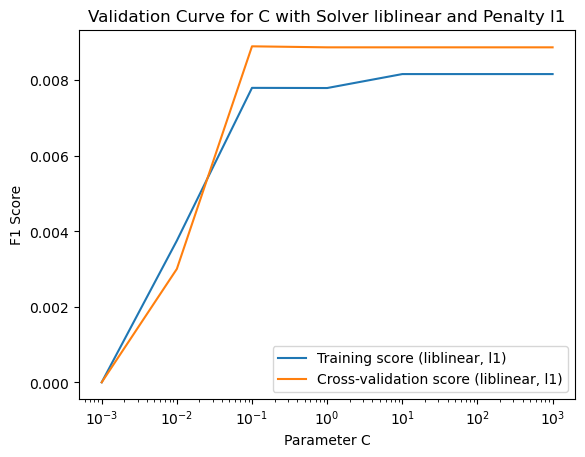

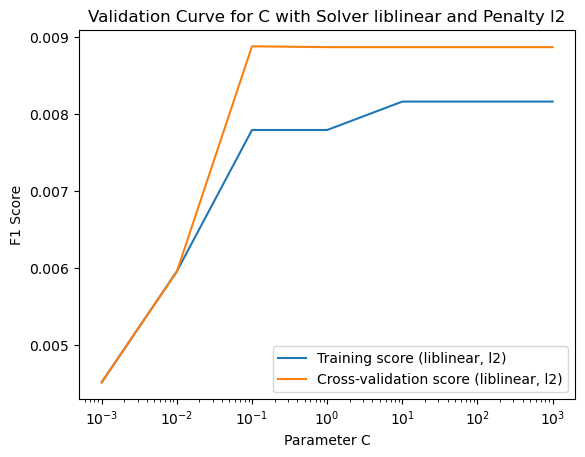

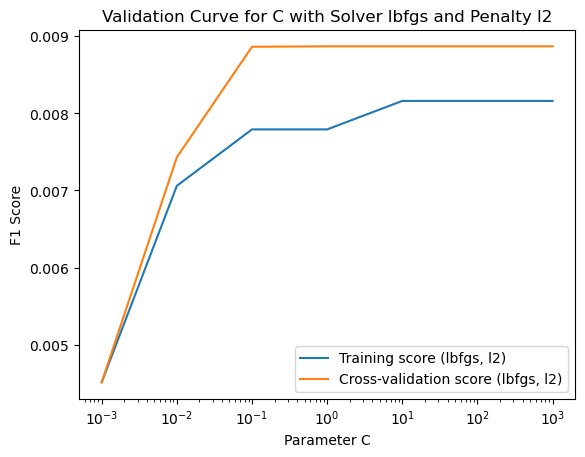

In [53]:
solvers = ['liblinear', 'lbfgs']
for solver in solvers:
    penalties = ['l1', 'l2'] if solver == 'liblinear' else ['l2']
    
    for penalty in penalties:
        train_scores, test_scores = validation_curve(
            LogisticRegression(penalty=penalty, solver=solver),
            X_train_sfs_lr, y_train, param_name='C', param_range=param_range,
            scoring='f1', n_jobs=-1, cv=5
        )
        
        plt.figure()
        plt.semilogx(param_range, np.mean(train_scores, axis=1), label=f'Training score ({solver}, {penalty})')
        plt.semilogx(param_range, np.mean(test_scores, axis=1), label=f'Cross-validation score ({solver}, {penalty})')
        plt.xlabel('Parameter C')
        plt.ylabel('F1 Score')
        plt.title(f'Validation Curve for C with Solver {solver} and Penalty {penalty}')
        plt.legend(loc='best')
        plt.show()


### RF

In [17]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=5)
sfs = SFS(rf_model,
          k_features=30,  
          forward=True,       
          floating=True,    
          scoring='average_precision',      
          cv=5)              

sfs = sfs.fit(X_train_rf, y_train)

selected_features = X_train_rf.columns[list(sfs.k_feature_idx_)]
print('Seçilen Özellikler:', selected_features)

Seçilen Özellikler: Index(['CC Num of application_L1M', 'Existing Credit Card Previous Limit',
       'LO Num of application_L6M', 'CC TS First Open Active Credit Card',
       'TS Last Closed good account', 'CC Num of application_L6M',
       'AMC_Transfer_Outstanding', 'Existing Customer Limit',
       'CC Total Payment of all Credit cards',
       'OD Tot Outstanding Balance YTL', 'Residential Status',
       'Time in Employment', 'Last Declared Monthly Income_L3M',
       'Employment Field', 'Tenure', 'LO Num of open accounts_L12M',
       'LO Number of closed good account', 'Total Assets_1',
       'LO TS First Open Date', 'MO Number of months in 1 delay_L6M',
       'Any Legal Action YN_Y', 'Last Credit Decision_P',
       'Last Credit Decision_R', 'Any Legal Action no date YN_Y',
       'PO Credit Exisits_YN_Y', 'CB Unpaid Notes_Cheques YN_Y',
       'OD_Pending Credit_YN_Y', 'Guarantee YN_Y',
       'Overridden_From_Final_Decline_YN_Y', 'CC Existing Customers in L6M_Y'],
      

In [18]:
selected_features = X_train_rf.columns[list(sfs.k_feature_idx_)]
X_train_sfs_rf = X_train_rf[selected_features]
X_test_sfs_rf = X_test_rf[selected_features]

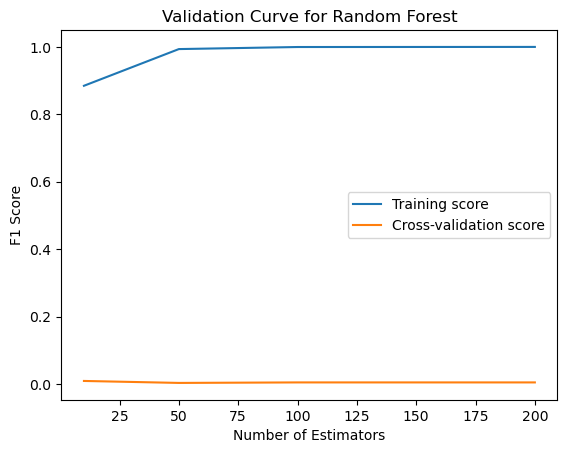

In [19]:
param_range = [10, 50, 100, 200]  
train_scores, test_scores = validation_curve(RandomForestClassifier(), X_train_sfs_rf, y_train, param_name='n_estimators', param_range=param_range, scoring='f1')

plt.figure()
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.title('Validation Curve for Random Forest')
plt.legend(loc='best')
plt.show()

### XGB

In [20]:
xgb_model = XGBClassifier(n_jobs=5, max_depth=3)
sfs = SFS(xgb_model,
          k_features=30,  
          forward=True,       
          floating=True,    
          scoring='average_precision',      
          cv=5)              

sfs = sfs.fit(X_train_xgb_lgb, y_train)

selected_features = X_train_xgb_lgb.columns[list(sfs.k_feature_idx_)]
print('Seçilen Özellikler:', selected_features)

Seçilen Özellikler: Index(['Existing Credit Card Previous Limit', 'LO Num of application_L6M',
       'CC TS First Open Active Credit Card', 'TS Last Closed good account',
       'CC Num of application_L6M', 'AMC_Transfer_Outstanding',
       'Existing Customer Limit', 'CC Total Payment of all Credit cards',
       'OD Tot Outstanding Balance YTL', 'Residential Status',
       'CC Number of months in 1 delay_L12M',
       'Last Declared Monthly Income_L3M', 'Tenure',
       'Existing Overdraft Limit', 'Verified Own Income Amount',
       'LO Num of open accounts_L12M', 'Total Amount of Open Mortgage Loans',
       'LO Number of closed good account', 'CC Worst Payment Status_L24M',
       'Total Assets_1', 'LO TS First Open Date',
       'MO Number of months in 1 delay_L6M', 'Any Legal Action YN_Y',
       'Last Credit Decision_P', 'Any Legal Action no date YN_Y',
       'PO Credit Exisits_YN_Y', 'CB Unpaid Notes_Cheques YN_Y',
       'OD_Pending Credit_YN_Y', 'Guarantee YN_Y',
       '

In [21]:
selected_features = X_train_xgb_lgb.columns[list(sfs.k_feature_idx_)]
X_train_sfs_xgb = X_train_xgb_lgb[selected_features]
X_test_sfs_xgb = X_test_xgb_lgb[selected_features]

In [22]:
# Hiperparametre aralıklarını tanımlayın
param_ranges = {
    'max_depth': np.arange(1, 21),
    'n_estimators': np.arange(50, 200, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10)
}

def plot_validation_curve(param_name, param_range, X_train, y_train):
    # XGBoost modelini tanımlayın
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    
    # Validation curve hesapla
    train_scores, test_scores = validation_curve(
        model, X_train, y_train, 
        param_name=param_name, 
        param_range=param_range, 
        scoring='average_precision', 
        n_jobs=-1
    )
    
    # Ortalama ve standart sapma hesapla
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot
    plt.figure()
    plt.title(f"Validation Curve with XGBoost")
    plt.xlabel(param_name)
    plt.ylabel("Average Precision")
    plt.ylim(0.0, 1.1)
    plt.grid()
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")
    
    # Şeritler çiz
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
    
    plt.legend(loc="best")
    plt.show()

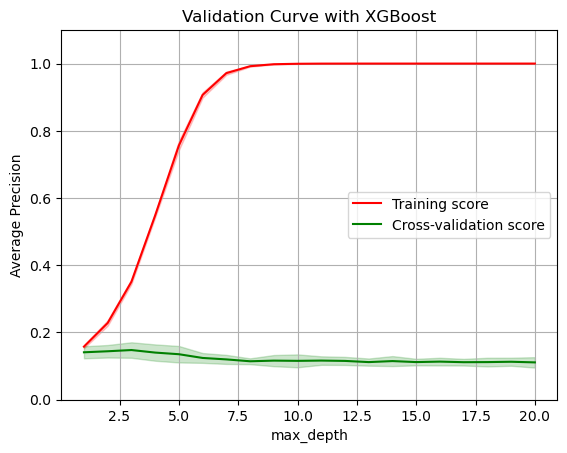

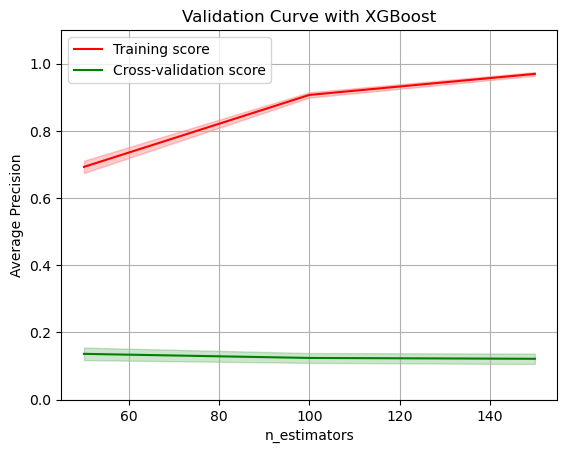

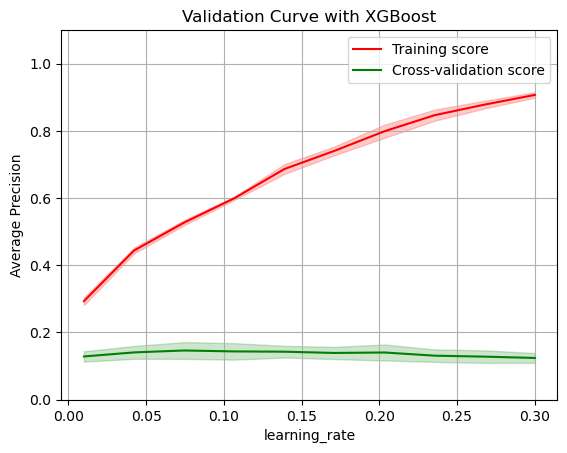

In [23]:
# Validation Curve'leri çizme
for param_name, param_range in param_ranges.items():
    plot_validation_curve(param_name, param_range, X_train_sfs_xgb, y_train)

### LGB

In [24]:
lgbm_model = LGBMClassifier(verbose=-1, n_jobs=5, max_depth=3)
sfs = SFS(lgbm_model,
          k_features=30,  
          forward=True,       
          floating=True,    
          scoring='average_precision',      
          cv=5)              

sfs = sfs.fit(X_train_xgb_lgb, y_train)

selected_features = X_train_xgb_lgb.columns[list(sfs.k_feature_idx_)]
print('Seçilen Özellikler:', selected_features)

Seçilen Özellikler: Index(['Existing Credit Card Previous Limit', 'LO Num of application_L6M',
       'CC TS First Open Active Credit Card', 'TS Last Closed good account',
       'CC Num of application_L6M', 'AMC_Transfer_Outstanding',
       'Existing Customer Limit', 'CC Total Payment of all Credit cards',
       'OD Tot Outstanding Balance YTL', 'Residential Status',
       'Time in Employment', 'Last Declared Monthly Income_L3M',
       'Employment Field', 'Tenure', 'Existing Overdraft Limit',
       'Verified Own Income Amount', 'LO Num of open accounts_L12M',
       'LO Number of closed good account', 'Total Assets_1',
       'LO TS First Open Date', 'MO Number of months in 1 delay_L6M',
       'Last Credit Decision_P', 'Home Phone YN_Y', 'Employers Address YN_Y',
       'CB Unpaid Notes_Cheques YN_Y', 'E Mail Given YN_Y',
       'OD_Pending Credit_YN_Y', 'Guarantee YN_Y',
       'Overridden_From_Final_Decline_YN_Y', 'CC Existing Customers in L6M_Y'],
      dtype='object')


In [25]:
selected_features = X_train_xgb_lgb.columns[list(sfs.k_feature_idx_)]
X_train_sfs_lgb = X_train_xgb_lgb[selected_features]
X_test_sfs_lgb = X_test_xgb_lgb[selected_features]

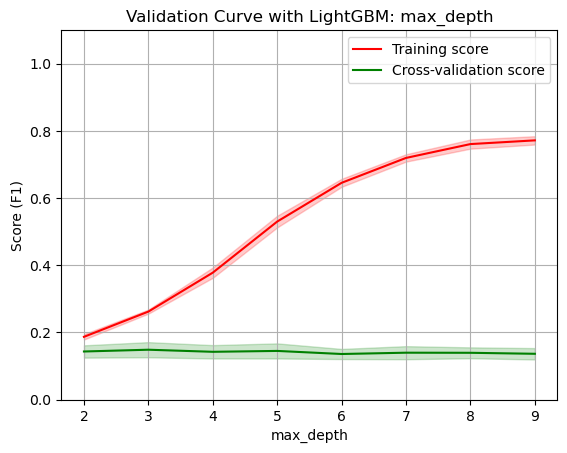

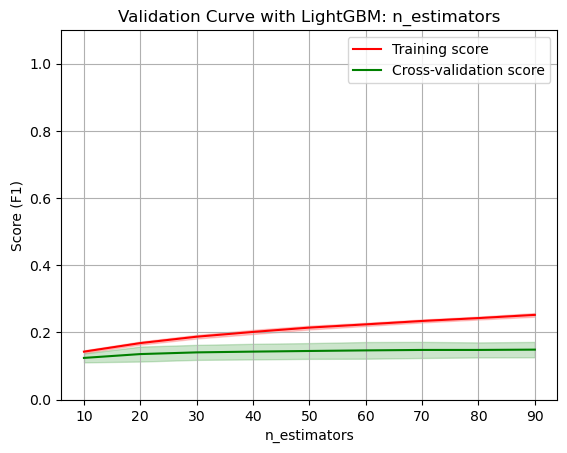

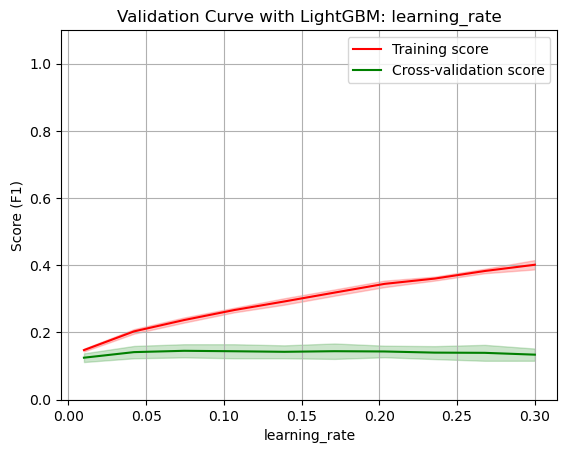

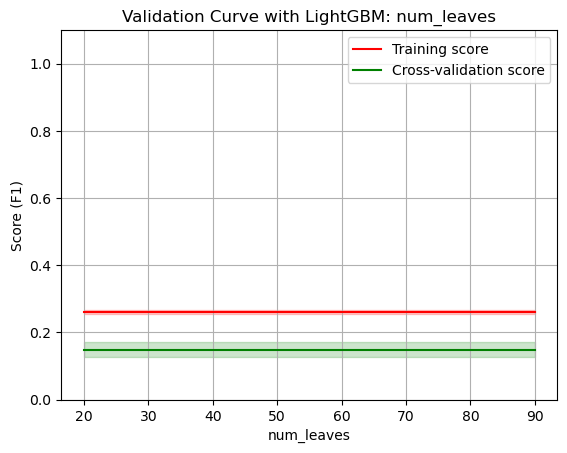

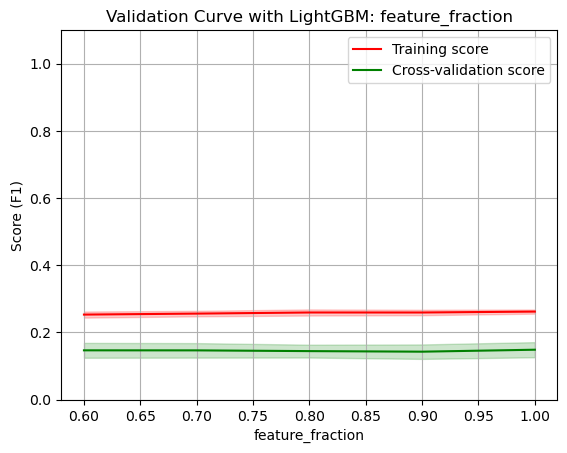

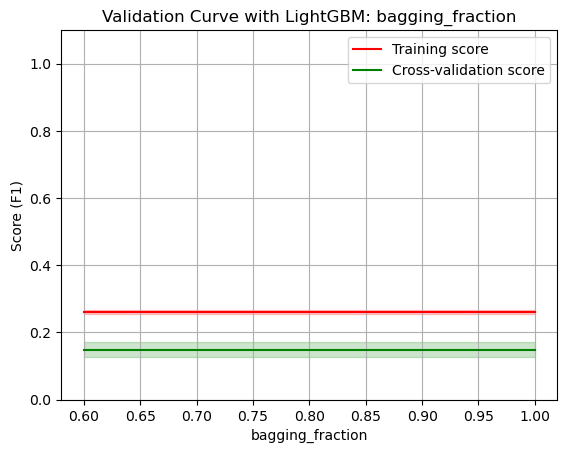

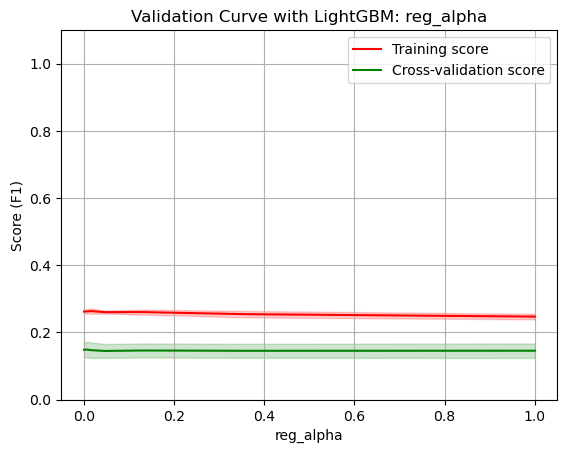

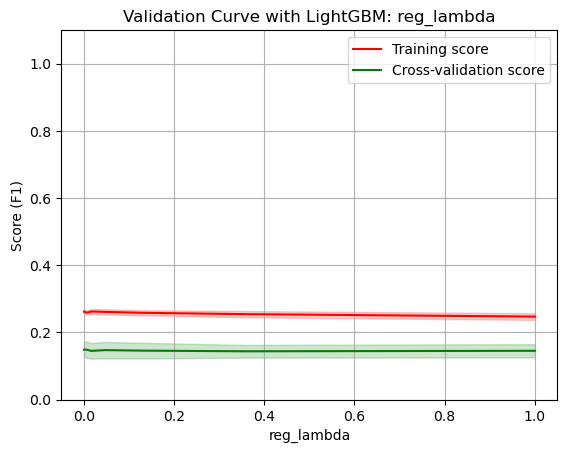

In [27]:
# Hiperparametre aralıklarını tanımlayın
param_ranges = {
    'max_depth': np.arange(2, 10, 1),
    'n_estimators': np.arange(10, 100, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'num_leaves': np.arange(20, 100, 10),
    'feature_fraction': np.linspace(0.6, 1.0, 5),
    'bagging_fraction': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.logspace(-4, 0, 10),  # L1 düzenleme için logaritmik aralık
    'reg_lambda': np.logspace(-4, 0, 10)  # L2 
                }

def plot_validation_curve(param_name, param_range, X_train, y_train):
    # LightGBM modelini tanımlayın
    model = LGBMClassifier(
        boosting_type='gbdt', 
        objective='binary',
        metric='binary_error',
        use_label_encoder=False,
        verbose=-1,
        max_depth=3
        )
    
    train_scores, test_scores = validation_curve(
        model, X_train, y_train, 
        param_name=param_name, 
        param_range=param_range, 
        scoring='average_precision', 
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(f"Validation Curve with LightGBM: {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score (F1)")
    plt.ylim(0.0, 1.1)
    plt.grid()
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")
    
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
    
    plt.legend(loc="best")
    plt.show()

for param_name, param_range in param_ranges.items():
    plot_validation_curve(param_name, param_range, X_train_sfs_lgb, y_train)


### Define Evaluation Functions

In [41]:
def evaluate_model_performance(y_test, y_pred, y_pred_proba, model_name="Model"):
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Precision-Recall AUC hesaplama
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)  # PR AUC hesaplama
    
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    print(f"{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.2f} (Ignore for unbalanced data)")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"PR AUC: {pr_auc:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"MCC: {mcc:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print("\nClassification Report:")
    print(class_report)

    
    

def plot_model_performance(y_test, y_pred_proba, model_name="Model"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(18, 5))

    # ROC Curve plot
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")

    # Precision-Recall Curve plot
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')

    # Calibration Curve plot
    plt.subplot(1, 3, 3)
    plt.plot(prob_pred, prob_true, marker='o', color='b', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Curve: {model_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

## ML Modeling

### Logistic Regression

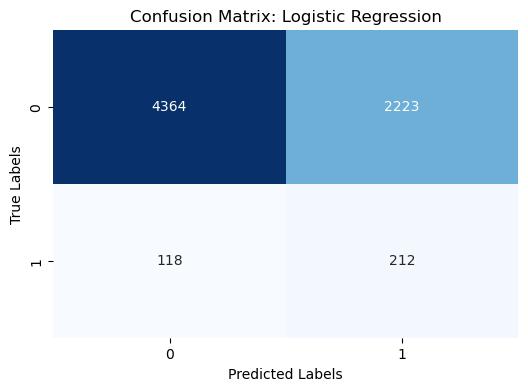

Logistic Regression Model Performance:
Accuracy: 0.66 (Ignore for unbalanced data)
ROC-AUC: 0.72
PR AUC: 0.13
F1-Score: 0.15
MCC: 0.14
Balanced Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      6587
           1       0.09      0.64      0.15       330

    accuracy                           0.66      6917
   macro avg       0.53      0.65      0.47      6917
weighted avg       0.93      0.66      0.76      6917



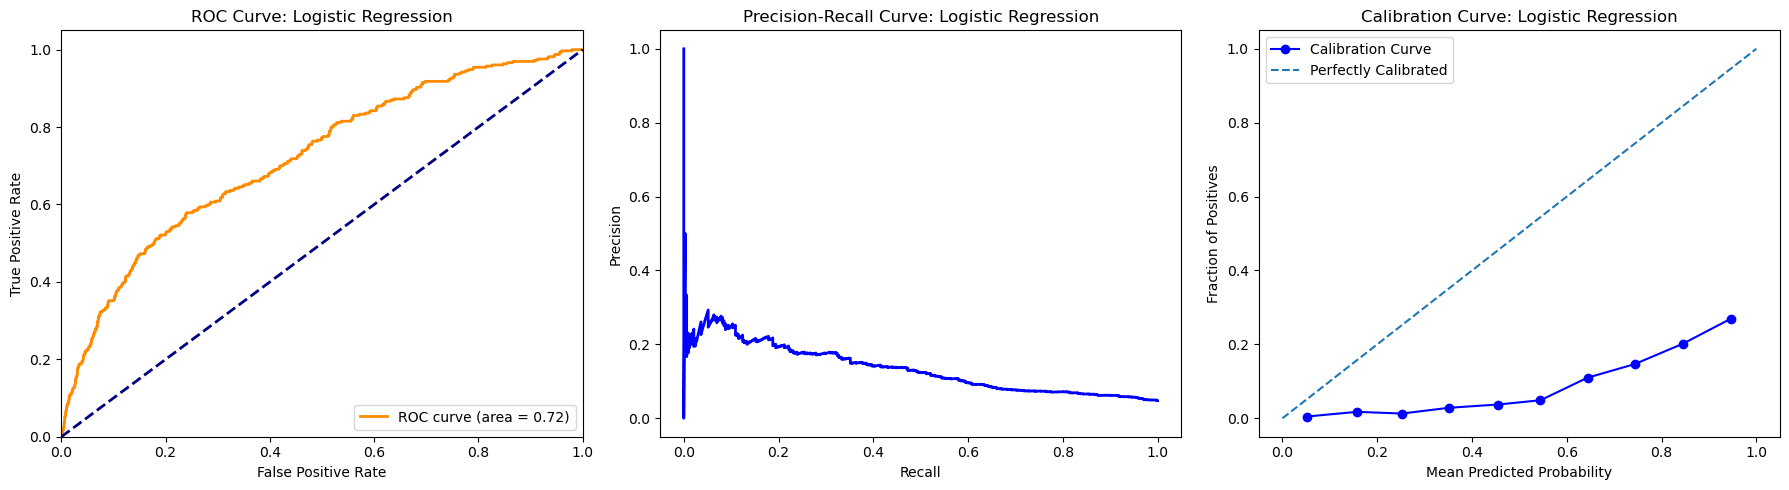

In [55]:
log_reg = LogisticRegression(C=5,class_weight='balanced', random_state=42,solver="liblinear", penalty="l1")
log_reg.fit(X_train_sfs_lr, y_train)

y_pred_lr = log_reg.predict(X_test_sfs_lr)
y_pred_proba_lr = log_reg.predict_proba(X_test_sfs_lr)[:, 1]

evaluate_model_performance(y_test, y_pred_lr, y_pred_proba_lr, model_name="Logistic Regression")
plot_model_performance(y_test, y_pred_proba_lr, model_name="Logistic Regression")

### Random Forest

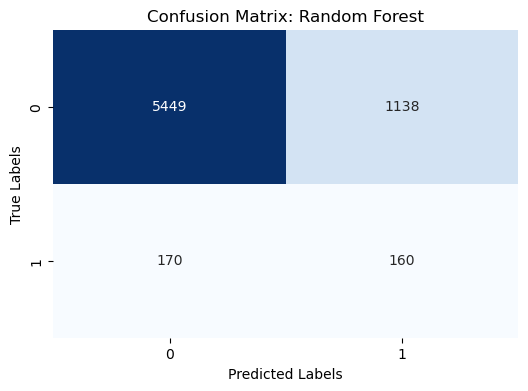

Random Forest Model Performance:
Accuracy: 0.81 (Ignore for unbalanced data)
ROC-AUC: 0.75
PR AUC: 0.14
F1-Score: 0.20
MCC: 0.17
Balanced Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      6587
           1       0.12      0.48      0.20       330

    accuracy                           0.81      6917
   macro avg       0.55      0.66      0.54      6917
weighted avg       0.93      0.81      0.86      6917



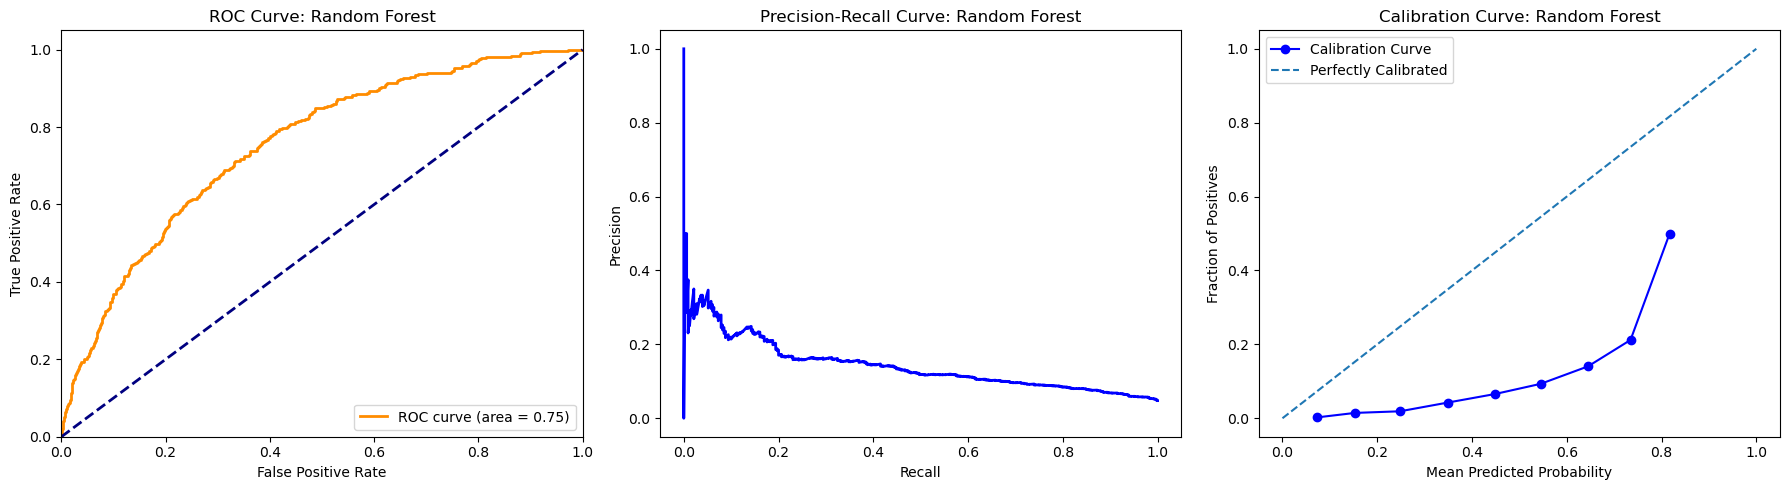

In [45]:
rf_model = RandomForestClassifier(
    class_weight="balanced",
    max_depth=20,  
    min_samples_leaf=50,  
    random_state=42  
)

rf_model.fit(X_train_sfs_rf, y_train)

y_pred_rf = rf_model.predict(X_test_sfs_rf)
y_pred_proba_rf = rf_model.predict_proba(X_test_sfs_rf)[:, 1]

evaluate_model_performance(y_test, y_pred_rf, y_pred_proba_rf, model_name="Random Forest")
plot_model_performance(y_test, y_pred_proba_rf, model_name="Random Forest")

### XGBoost

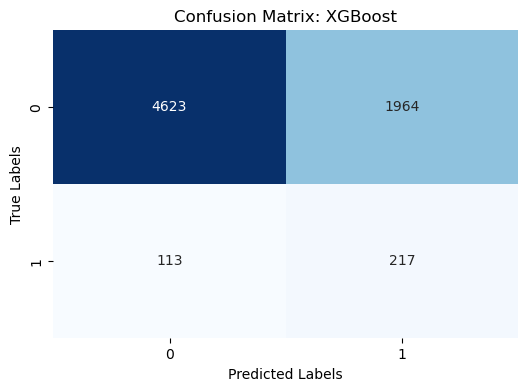

XGBoost Model Performance:
Accuracy: 0.70 (Ignore for unbalanced data)
ROC-AUC: 0.74
PR AUC: 0.14
F1-Score: 0.17
MCC: 0.16
Balanced Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      6587
           1       0.10      0.66      0.17       330

    accuracy                           0.70      6917
   macro avg       0.54      0.68      0.49      6917
weighted avg       0.93      0.70      0.79      6917



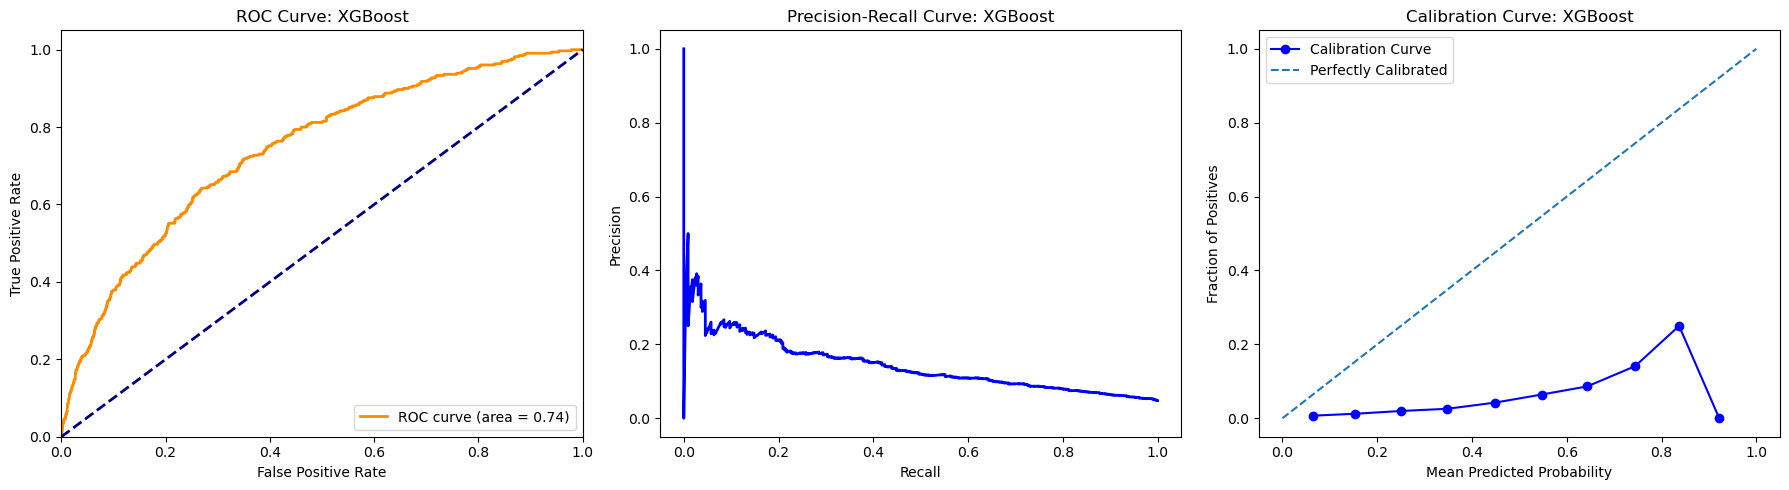

In [46]:
# Pozitif ve negatif sınıf oranlarına göre scale_pos_weight hesapla
pos_class_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_model = XGBClassifier(max_depth=2, scale_pos_weight=pos_class_weight, n_estimators=60, learning_rate=0.2)

xgb_model.fit(X_train_sfs_xgb, y_train)

y_pred_xgb = xgb_model.predict(X_test_sfs_xgb)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_sfs_xgb)[:, 1]

evaluate_model_performance(y_test, y_pred_xgb, y_pred_proba_xgb, model_name="XGBoost")
plot_model_performance(y_test, y_pred_proba_xgb, model_name="XGBoost")

### LightGBM

In [47]:
lgb_train_data = lgb.Dataset(X_train_sfs_lgb, label=y_train)
lgb_test_data = lgb.Dataset(X_test_sfs_lgb, label=y_test, reference=lgb_train_data)

params = {
    'objective': 'binary',       # Binary classification problemi
    'metric': 'binary_logloss',  
    'boosting': 'gbdt',       # Gradient boosting ile modelleme
    'max_depth': 3,
    'n_estimators':50,
    'is_unbalance': True,
    'learning_rate': 0.03,
    'num_leaves': 15,
    'reg_alpha':1,
    'reg_lambda':1,
    'verbose': -1  
}

/Users/bora/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


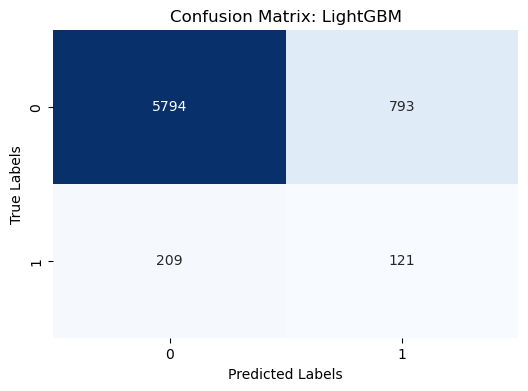

LightGBM Model Performance:
Accuracy: 0.86 (Ignore for unbalanced data)
ROC-AUC: 0.73
PR AUC: 0.13
F1-Score: 0.19
MCC: 0.16
Balanced Accuracy: 0.62

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      6587
           1       0.13      0.37      0.19       330

    accuracy                           0.86      6917
   macro avg       0.55      0.62      0.56      6917
weighted avg       0.93      0.86      0.89      6917



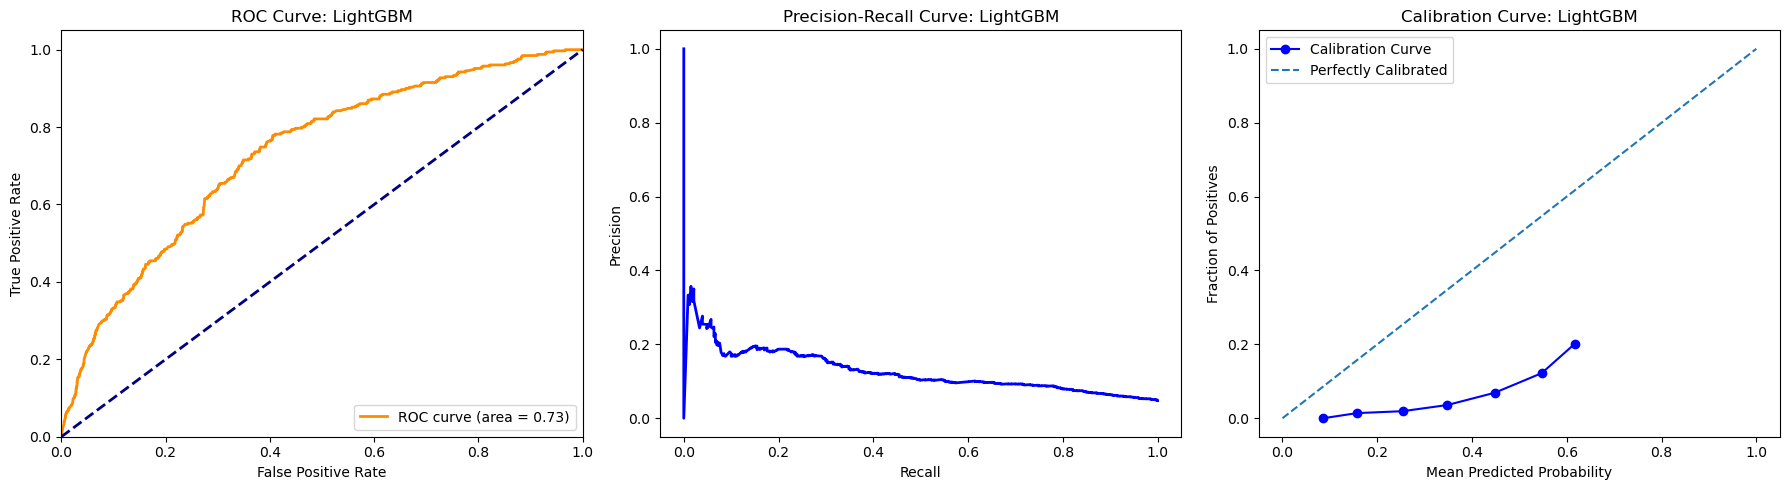

In [48]:
lgb_model = lgb.train(params, lgb_train_data, num_boost_round=100, valid_sets=[lgb_train_data, lgb_test_data])

y_pred_proba_lgb = lgb_model.predict(X_test_sfs_lgb, num_iteration=lgb_model.best_iteration)  # Olasılık tahminleri
y_pred_lgb = (y_pred_proba_lgb > 0.5).astype(int)  

evaluate_model_performance(y_test, y_pred_lgb, y_pred_proba_lgb, model_name="LightGBM")
plot_model_performance(y_test, y_pred_proba_lgb, model_name="LightGBM")

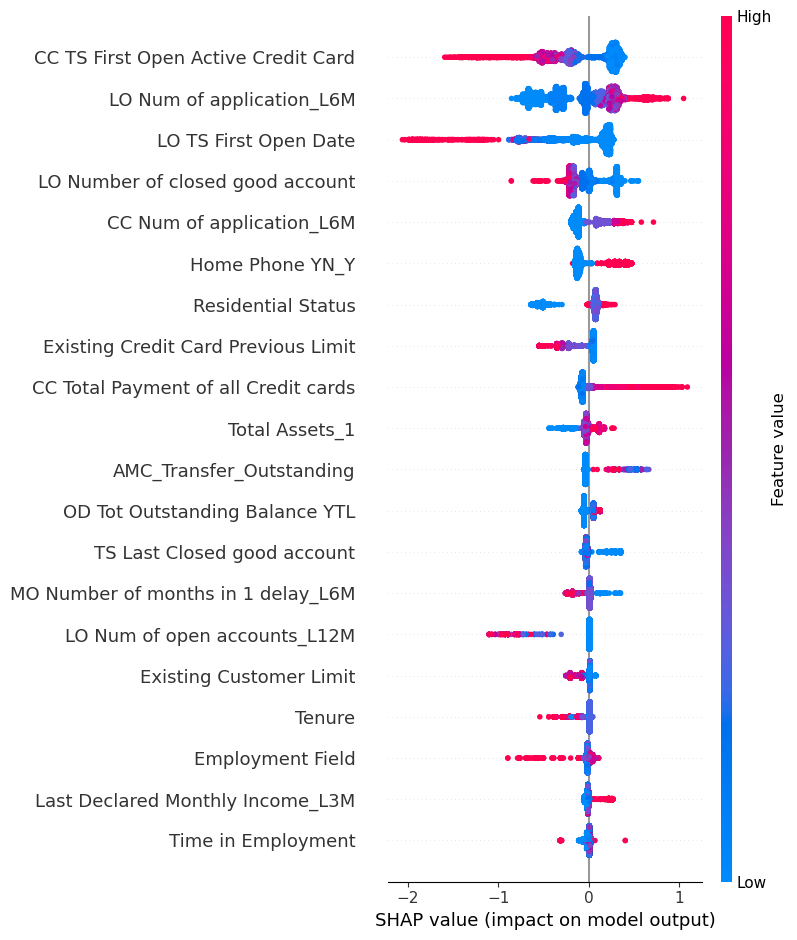

In [38]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sfs_xgb)

shap.summary_plot(shap_values, X_test_sfs_xgb, feature_names=selected_features)

/Users/bora/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


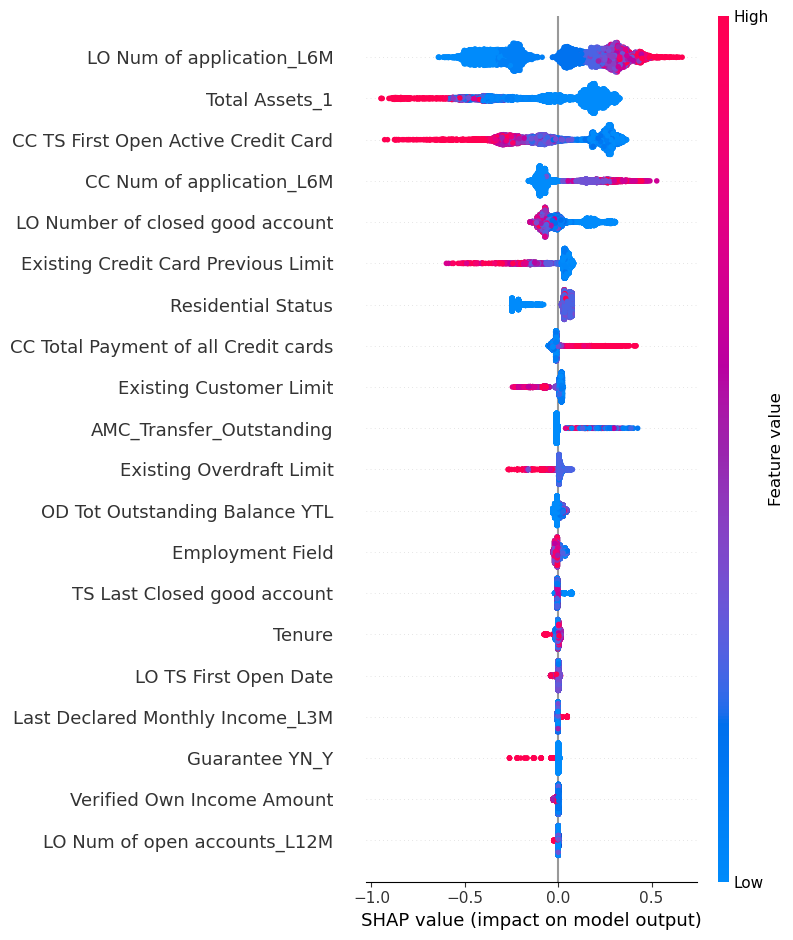

In [36]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test_sfs_lgb)

shap.summary_plot(shap_values, X_test_sfs_lgb, feature_names=selected_features)